In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn import metrics
import scipy as sp
from scipy.spatial import distance_matrix

from diffusion_functions import *
from semi_supervised_manifold_learning import *
from animate_diffusion import animate_diffusion

# commands for displaying animations in jupyter notebook
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

# Concentric spheres in increasing dimensions

## Helper functions

In [21]:
def format_axes(ax, titlestring):
    # figure formatting
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axis('off')
    if not titlestring==None:
        ax.set_title(titlestring)
    return

def plot_label_comparison_colorful(ax, label_vector, data_matrix, titlestring=None):
    threshold = 0 
    label_estimates = label_vector#make_sweep_cut(label_vector, threshold)

    im = ax.scatter(data_matrix[:,0],data_matrix[:,1],c=label_estimates)
    plt.colorbar(im, ax=ax)
    
    format_axes(ax,titlestring)
    return

def plot_label_comparison_binary(ax, label_vector, data_matrix, titlestring=None, 
                                 objective_function = sweep_cut_classification_error):
    
    cut_val, threshold = find_min_sweepcut(label_vector,100,objective_function, orthogonality_constraint = 'auto')
    label_estimates = make_sweep_cut(label_vector, threshold)
    
    classification_error = sweep_cut_classification_error(label_estimates)
    orthogonality_error = np.abs(np.sum(label_estimates)/len(label_estimates))

    im = ax.scatter(data_matrix[:,0],data_matrix[:,1],c=label_estimates)
    plt.colorbar(im, ax=ax)
    
    subtitle = f'\n Threshold = {threshold:.3f}. Cut objective = {cut_val:.3f} \n Class. error = {classification_error:.3f} \n Orthog. error = {orthogonality_error:.3f}'
    format_axes(ax,titlestring+subtitle)
    return

def plot_AUC_hist(AUC_vals, titlestring = None):
    plt.rcParams.update({'font.size': 15})
    # get bin parameters for consistent scaling of both datasets without displaying
    _, first_bins, _ = plt.hist([[v[1] for v in AUC_vals], [v[0] for v in AUC_vals]])
    plt.clf()
    
    fig, ax = plt.subplots(figsize = (6, 5))
    ax.hist([v[1] for v in AUC_vals], bins = first_bins, alpha=0.5, edgecolor = 'black', label = 'graph')
    ax.hist([v[0] for v in AUC_vals], bins = first_bins, alpha=0.5, edgecolor = 'black', label='hypergraph')
#     ax.hist([v[1] for v in AUC_vals], alpha=0.5, edgecolor = 'black', label = 'graph')
#     ax.hist([v[0] for v in AUC_vals], alpha=0.5, edgecolor = 'black', label='hypergraph')
    ax.legend()
    
    # figure formatting 
    ax.set_title(titlestring)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plt.show()
    return

def compare_ROC_curves(hypergraph_x, graph_x):
    n = len(hypergraph_x)
    labels = np.hstack([np.full(shape=int(n/2),fill_value = -1),np.full(shape=int(n/2),fill_value = 1)])
    
    plt.plot(figsize=(15, 15))
    for x, legend_val in [(graph_x, 'graph'),(hypergraph_x, 'hypergraph')]:
        fpr, tpr, thresholds = metrics.roc_curve(labels, x, pos_label=1)
        plt.plot(fpr, tpr, label = legend_val)
    
    graph_auc_score = metrics.roc_auc_score(labels, graph_x)
    hypergraph_auc_score = metrics.roc_auc_score(labels, hypergraph_x)
    
    plt.legend()
    plt.title('ROC curves \n hyper AUC score = '+str(hypergraph_auc_score)+' \n graph AUC score = '+str(graph_auc_score))
    plt.show()
    return

## Visualization in 2D

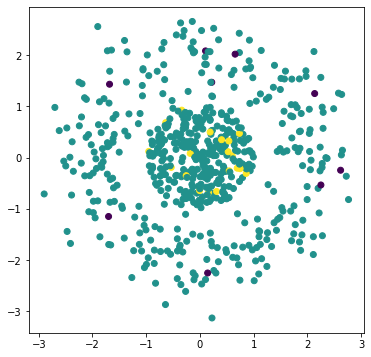

In [3]:
# generate new data
_, data_matrix = generate_concentric_highdim(ambient_dim = 2,verbose = False) #start_theta=np.pi / 5, num_rotations=0.9, verbose=False)
n = data_matrix.shape[0]

num_rand_seeds = int(0.05*n)
x0 = np.full(shape=(n, 1), fill_value=0)
random_seeds = np.random.choice(np.arange(n), size=num_rand_seeds)
x0[random_seeds[random_seeds < n / 2]] = -1
x0[random_seeds[random_seeds > n / 2]] = 1

fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(data_matrix[:, 0], data_matrix[:, 1],c=x0)
plt.show()

## AUC Histograms for varying dimension

<Figure size 432x288 with 0 Axes>

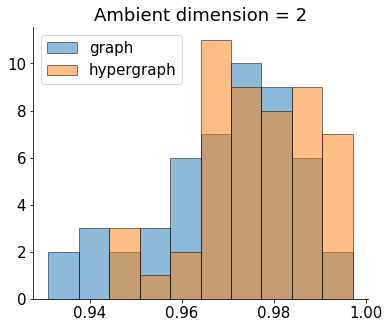

<Figure size 432x288 with 0 Axes>

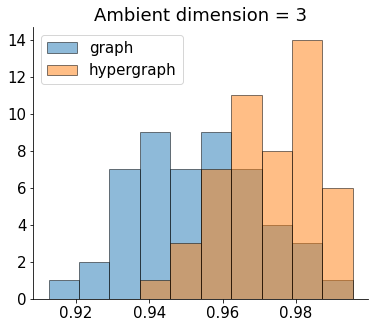

<Figure size 432x288 with 0 Axes>

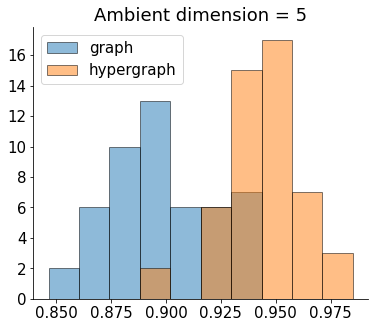

<Figure size 432x288 with 0 Axes>

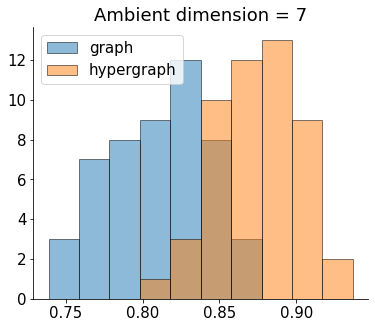

In [23]:
# data generation parameters
r_inner=1
r_outer=2
pts_per_community=300
noise_level=0.4

n = 2*pts_per_community
labels = np.hstack([np.full(shape=int(n/2),fill_value = -1),np.full(shape=int(n/2),fill_value = 1)])

# experimental procedure parameters
k = 5
num_trials = 50
PPR_iterations = 50

for ambient_dim in [2,3,5,7]:
    AUC_vals = []
    for trial in range(num_trials):
        # generate new data
        _, data_matrix = generate_concentric_highdim(ambient_dim=ambient_dim,
                                                     r_inner=r_inner,
                                                     r_outer=r_outer,
                                                     n_pts=pts_per_community,
                                                     noise_level=noise_level,
                                                     verbose=False)

        # build graph/hypergraph
        knn_adj_matrix = build_knn_graph(data_matrix,k)
        knn_hgraph_dict = build_knn_hypergraph(data_matrix,k)

        # cluster using PPR vector
        hypergraph_diff_results, graph_diff_results = PPR_knn_clustering(knn_adj_matrix,
                        knn_hgraph_dict, num_iterations = PPR_iterations, verbose = False)

        hypergraph_x = hypergraph_diff_results['x_out']
        graph_x = graph_diff_results['x_out']

        graph_auc_score = metrics.roc_auc_score(labels, graph_x)
        hypergraph_auc_score = metrics.roc_auc_score(labels, hypergraph_x)
            
        AUC_vals.append((hypergraph_auc_score, graph_auc_score))
    plot_AUC_hist(AUC_vals,titlestring = f'Ambient dimension = {ambient_dim}') 